# Module 4 Session 6 - Modeling social determinants of health
## Author: Sonali Gupta
### Date: May 29, 2024
# Section 1 - Data exploration

In [2]:
rm(list=ls())
set.seed(13)

library("data.table")
library("dplyr")
library("parallel")
library('stringr')
library('ggplot2')



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Load the files for our cohort.

##########################!!!!!!
### CHANGE PATH!!!!!

cohort = as.data.frame(fread("ParticipantCohort-iSDI.tsv"))
range(cohort$ParticipantID)
dim(cohort)
head(cohort)

T2D = as.data.frame(fread("T2D.tsv"))
dim(T2D)
head(T2D)

[1] 10002913 99998921

[1] 50000     5

,ParticipantID,SIRE,Sex,Age,iSDI
,<int>,<chr>,<chr>,<int>,<dbl>
1,10002913,White,F,56,3.381389
2,10004024,White,F,45,3.415456
3,10004283,White,F,48,3.341311
4,10008277,Hispanic,F,69,3.593437
5,10008516,Hispanic,F,44,3.529948
6,10009190,White,F,53,3.332409


[1] 50000     2

,ParticipantID,t2d
,<int>,<int>
1,10002913,0
2,10004024,0
3,10004283,0
4,10008277,0
5,10008516,0
6,10009190,0


In [4]:
#Explore the data a little bit.
cohort %>% count(SIRE, Sex)
cohort %>% group_by(SIRE, Sex) %>% summarize(MeanAge = mean(Age))

SIRE,Sex,n
<chr>,<chr>,<int>
Black,F,4598
Black,M,2831
Hispanic,F,7516
Hispanic,M,2910
White,F,20384
White,M,11761


`summarise()` has grouped output by 'SIRE'. You can override using the
`.groups` argument.


SIRE,Sex,MeanAge
<chr>,<chr>,<dbl>
Black,F,47.79165
Black,M,47.82868
Hispanic,F,49.11283
Hispanic,M,49.08144
White,F,47.14148
White,M,47.13145


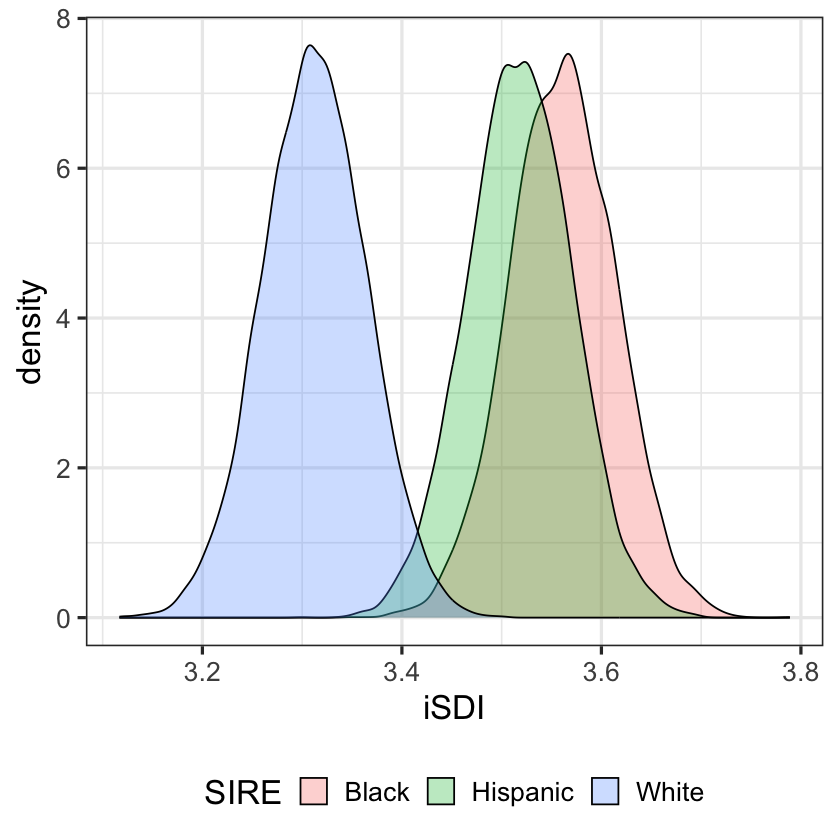

In [5]:
# Visualzie the density of age distribution.

ggplot(cohort, aes(x = iSDI, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


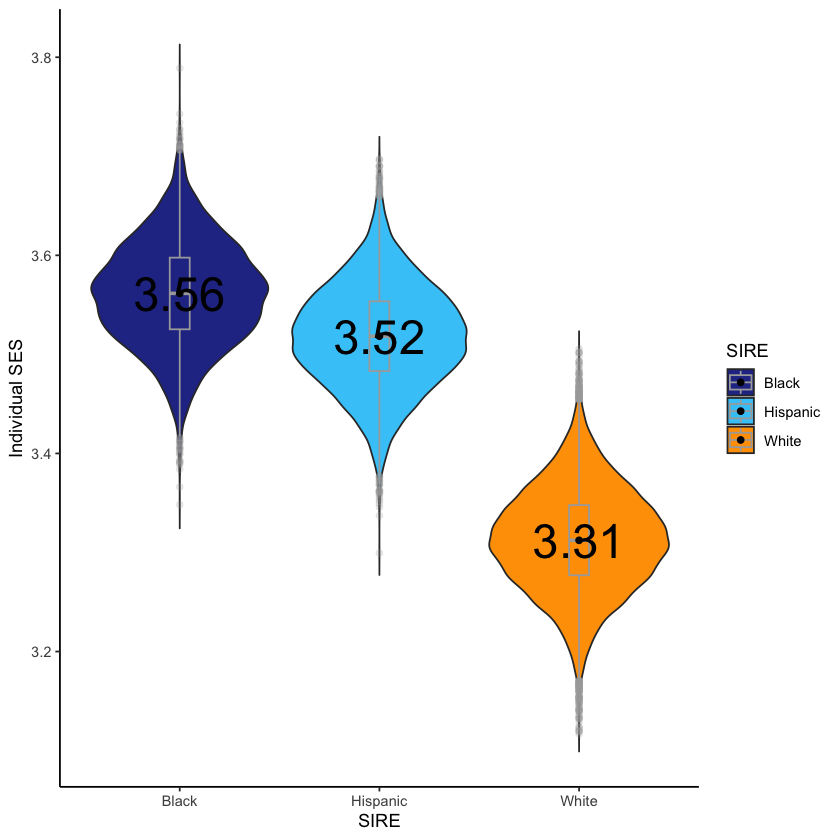

In [6]:
# Visualise the individual SES distribution across SIRE groups

library("ggplot2")
ggplot(cohort, aes(x=SIRE, y=iSDI, fill = SIRE)) + 
  geom_violin(trim = FALSE) + labs(x ="SIRE", y = "Individual SES")+
geom_boxplot(width=0.1, color="darkgrey", alpha=0.2) +
geom_text(data = cohort %>% group_by(SIRE) %>% summarise(median_V1 = median(iSDI, na.rm = TRUE)),
            aes(x = SIRE, y = median_V1, label = round(median_V1, 2)),
            size = 10, position = position_dodge(0.1))+
scale_fill_manual(values=c("#283593", "#41C9F8", "#FFA000"))+
stat_summary(fun = "median",
               geom = "point",
               color = "black")+
theme(panel.border = element_rect(colour = "black", fill=NA, size=0.5),
      axis.text.y   = element_text(size=100),
      axis.text.x   = element_text(size=100),
      axis.title.x = element_text(size=100),
      axis.title.y = element_text(size=100),
      legend.text=element_text(size=100))+
theme_classic() 

### Modelling individual SES with SIRE

In [23]:
cohort$Sex <- as.factor(cohort$Sex)  
cohort$SIRE <- as.factor(cohort$SIRE) 

#Set White Female as reference as we are studying disparities with reference to white ethnci group
cohort$Sex <- relevel(cohort$Sex, ref = "F")
cohort$SIRE <- relevel(cohort$SIRE, ref = "White")
model <-  glm(iSDI~SIRE+Age+Sex, data=cohort)
summary(model)


Call:
glm(formula = iSDI ~ SIRE + Age + Sex, data = cohort)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.218756  -0.033680  -0.000105   0.033922   0.223240  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.384e+00  1.364e-03 2481.63   <2e-16 ***
SIREBlack     2.497e-01  6.430e-04  388.28   <2e-16 ***
SIREHispanic  2.106e-01  5.669e-04  371.44   <2e-16 ***
Age          -1.658e-03  2.808e-05  -59.05   <2e-16 ***
SexM          1.829e-02  4.695e-04   38.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.00249261)

    Null deviance: 719.36  on 49999  degrees of freedom
Residual deviance: 124.62  on 49995  degrees of freedom
AIC: -157820

Number of Fisher Scoring iterations: 2


In [ ]:
# From the above results it is clear that iSDI is significantly associated with black and hispanic SIRE groups

### Distribution of SED across SIRE groups with ANOVA

In [7]:
anova_result <- aov(iSDI~SIRE,
  data = cohort
)
summary(anova_result)

               Df Sum Sq Mean Sq F value Pr(>F)    
SIRE            2  582.3   291.1  106172 <2e-16 ***
Residuals   49997  137.1     0.0                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Modelling Disease Disparities

In [8]:
# Merge cohort and T2D
merged_cohort <- merge(cohort, T2D, on = ParticipantID)

In [9]:
head(merged_cohort)

,ParticipantID,SIRE,Sex,Age,iSDI,t2d
,<int>,<chr>,<chr>,<int>,<dbl>,<int>
1,10002913,White,F,56,3.381389,0
2,10004024,White,F,45,3.415456,0
3,10004283,White,F,48,3.341311,0
4,10008277,Hispanic,F,69,3.593437,0
5,10008516,Hispanic,F,44,3.529948,0
6,10009190,White,F,53,3.332409,0


In [12]:
#calculate T2D prevalence per SIRE group
PrevalenceWhite <- sum(merged_cohort[merged_cohort$SIRE == "White", ]$t2d == 1)*100/nrow(merged_cohort)
PrevalenceBlack <- sum(merged_cohort[merged_cohort$SIRE == "Black", ]$t2d == 1)*100/nrow(merged_cohort)
PrevalenceHispanic <- sum(merged_cohort[merged_cohort$SIRE == "Hispanic", ]$t2d == 1)*100/nrow(merged_cohort)

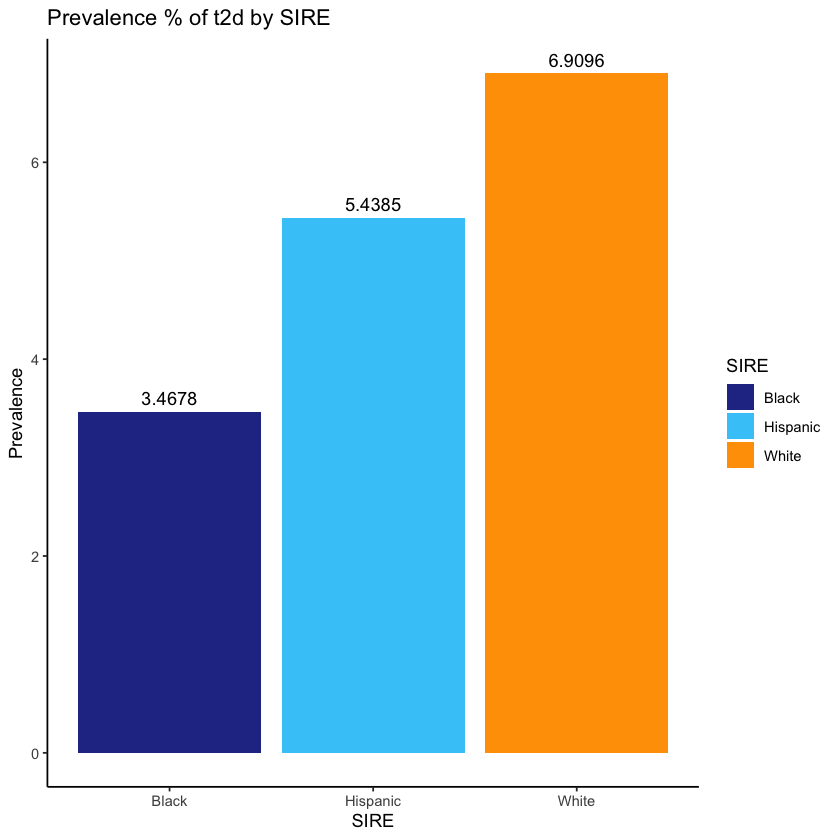

In [13]:
#create a bar plot
prevalence_data <- data.frame(
  SIRE = c("White", "Black", "Hispanic"),
  Prevalence = c(PrevalenceWhite, PrevalenceBlack, PrevalenceHispanic)
)

# Generate the bar plot using ggplot2
ggplot(prevalence_data, aes(x = SIRE, y = Prevalence, fill = SIRE)) +
  geom_bar(stat = "identity") +
  labs(title = "Prevalence % of t2d by SIRE",
       x = "SIRE",
       y = "Prevalence") +
  theme_classic() +
scale_fill_manual(values = c("White" = "#FFA000", "Black" = "#283593", "Hispanic" = "#41C9F8"))+
geom_text(aes(label = round(Prevalence, 4)), vjust = -0.5)

# Section 2 - Modelling T2D Disparities

In [27]:
# Modelling T2D without Individual SES
merged_cohort$Sex <- as.factor(merged_cohort$Sex)  
merged_cohort$SIRE <- as.factor(merged_cohort$SIRE) 

#Set White Female as reference as we are studying disparities with reference to white ethnci group
merged_cohort$Sex <- relevel(merged_cohort$Sex, ref = "F")
merged_cohort$SIRE <- relevel(merged_cohort$SIRE, ref = "White")

UnadjustedModel <-  glm(t2d~SIRE+Age+Sex, data=merged_cohort)
summary(UnadjustedModel)


Call:
glm(formula = t2d ~ SIRE + Age + Sex, data = merged_cohort)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.43215  -0.18798  -0.11757  -0.05931   1.05140  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.1737537  0.0097009 -17.911  < 2e-16 ***
SIREBlack     0.1218151  0.0045752  26.625  < 2e-16 ***
SIREHispanic  0.1434557  0.0040328  35.572  < 2e-16 ***
Age           0.0058265  0.0001998  29.165  < 2e-16 ***
SexM          0.0179639  0.0033404   5.378 7.57e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.126247)

    Null deviance: 6661.5  on 50031  degrees of freedom
Residual deviance: 6315.8  on 50027  degrees of freedom
AIC: 38450

Number of Fisher Scoring iterations: 2


In [28]:
# Modelling T2D with Individual SES
AdjustedModel <-  glm(t2d~iSDI+SIRE+Age+Sex, data=merged_cohort)
summary(AdjustedModel)


Call:
glm(formula = t2d ~ iSDI + SIRE + Age + Sex, data = merged_cohort)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.43237  -0.18902  -0.11739  -0.05959   1.05073  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.2291436  0.1081235  -2.119   0.0341 *  
iSDI          0.0163684  0.0318230   0.514   0.6070    
SIREBlack     0.1177284  0.0091685  12.841  < 2e-16 ***
SIREHispanic  0.1400093  0.0078204  17.903  < 2e-16 ***
Age           0.0058537  0.0002066  28.329  < 2e-16 ***
SexM          0.0176645  0.0033907   5.210  1.9e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1262489)

    Null deviance: 6661.5  on 50031  degrees of freedom
Residual deviance: 6315.7  on 50026  degrees of freedom
AIC: 38451

Number of Fisher Scoring iterations: 2


In [42]:
# Comparing Black betas

Blacktvalue <- (summary(UnadjustedModel)$coefficients[2]-summary(AdjustedModel)$coefficients[3])/(sqrt(summary(AdjustedModel)$coefficients[3]^2 + summary(UnadjustedModel)$coefficients[2]^2))
Blacktvalue

[1] 0.02412392

In [43]:
# Comparing Hispanic betas

Hispanictvalue <- (summary(UnadjustedModel)$coefficients[3]-summary(AdjustedModel)$coefficients[4])/(sqrt(summary(AdjustedModel)$coefficients[4]^2 + summary(UnadjustedModel)$coefficients[3]^2))
Hispanictvalue

[1] 0.01719286

# Section 3 - Mediation Analysis